In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import os
import torch
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from torch.utils.data import TensorDataset

## File path in Kaggle dataset

In [4]:
DATA_PATH = '/kaggle/input/extracted-text-data/extracted_text_data_largedata (9.9k).csv'
OUTPUT_DIR = '/kaggle/working/textdata'
os.makedirs(OUTPUT_DIR, exist_ok=True)

## Load the data

In [5]:
df = pd.read_csv(DATA_PATH)
print(f"Loaded {len(df)} rows")

Loaded 9954 rows


In [6]:
# Show columns and data types
print(df.info())

# Display basic statistics for numeric and categorical columns
print(df.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9954 entries, 0 to 9953
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image_path      9954 non-null   object
 1   label           9954 non-null   object
 2   extracted_text  9954 non-null   object
dtypes: object(3)
memory usage: 233.4+ KB
None
                                               image_path label extracted_text
count                                                9954  9954           9954
unique                                               9954     2           9771
top     /content/drive/MyDrive/for_text/fake/BN_text/p...  fake     মাছরাঙা HD
freq                                                    1  5447             21


In [7]:
df.head(5)

,image_path,label,extracted_text
0,/content/drive/MyDrive/for_text/fake/BN_text/p...,fake,থমথমে কক্সবাজার\nশেখ হাসিনার ফাইনাল একশন শুরু\...
1,/content/drive/MyDrive/for_text/fake/BN_text/q...,fake,ব্রেকিং নিউজ\nহায় হায়! খেলা শেষ ড. ইউনূসের?\nহ...
2,/content/drive/MyDrive/for_text/fake/BN_text/q...,fake,JAMUNA | tv\nna | tv\nপদের\nপেকোরে\nংলাদে\nউপ\...
3,/content/drive/MyDrive/for_text/fake/BN_text/p...,fake,উপলব ট্রাইবুনা\nমাননীয় প্রধানমন্ত্রী দেশরত্ন ...
4,/content/drive/MyDrive/for_text/fake/BN_text/q...,fake,১২/৩/২৪\nনি ক\nবাংলাদেশ\nনির্বাচন নিয়ে বিএনপির...


### Drop duplicates and reset index

In [8]:
num_duplicate_rows = df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicate_rows}")

Number of duplicate rows: 0


In [9]:
df = df.drop_duplicates().reset_index(drop=True)

### Visualize Label Distribution

In [11]:
df['label'].value_counts()

label
fake    5447
real    4507
Name: count, dtype: int64

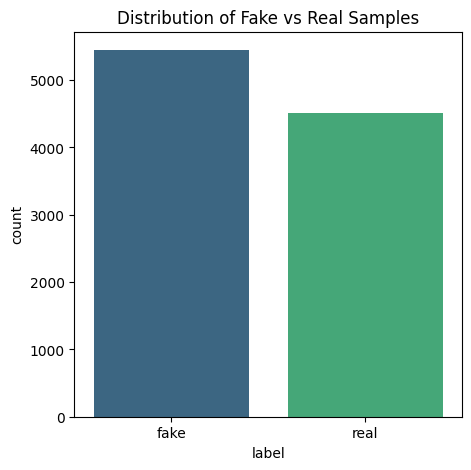

In [12]:
plt.figure(figsize=(5,5))
sns.countplot(x='label', data=df, palette='viridis', order=df['label'].value_counts().index)
plt.title('Distribution of Fake vs Real Samples')
plt.show()

## Extract language from image path

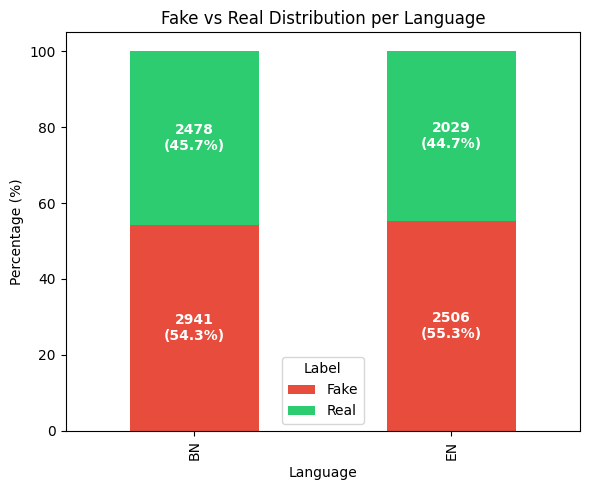

In [13]:
import re

def extract_language(path):
    if '/BN_text/' in path:
        return 'BN'
    elif '/EN_text/' in path:
        return 'EN'
    else:
        return 'Other'

df['language'] = df['image_path'].apply(extract_language)
# Use only BN & EN
df_plot = df[df['language'].isin(['BN','EN'])]

# Create contingency table
ct = pd.crosstab(df_plot['language'], df_plot['label'])

# Convert to percentage
ct_pct = ct.div(ct.sum(axis=1), axis=0) * 100

# Plot
ct_pct.plot(
    kind='bar',
    stacked=True,
    figsize=(6,5),
    color=['#E74C3C', '#2ECC71']
)

# Add labels
for i, lang in enumerate(ct.index):
    cumulative = 0
    for label in ct.columns:
        value = ct.loc[lang, label]
        pct = ct_pct.loc[lang, label]
        plt.text(
            i,
            cumulative + pct/2,
            f"{value}\n({pct:.1f}%)",
            ha='center',
            va='center',
            fontsize=10,
            color='white',
            fontweight='bold'
        )
        cumulative += pct

plt.title('Fake vs Real Distribution per Language')
plt.xlabel('Language')
plt.ylabel('Percentage (%)')
plt.legend(['Fake','Real'], title='Label')
plt.tight_layout()
plt.show()

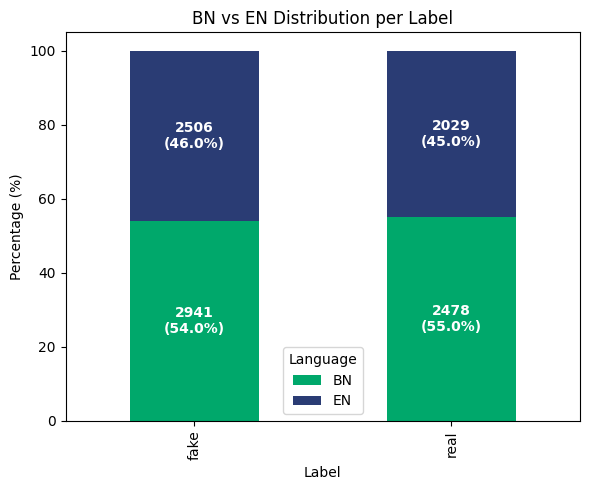

In [14]:
# Create contingency table (Label × Language)
ct_label = pd.crosstab(df_plot['label'], df_plot['language'])

# Convert to percentage per label
ct_label_pct = ct_label.div(ct_label.sum(axis=1), axis=0) * 100

# Plot
ct_label_pct.plot(
    kind='bar',
    stacked=True,
    figsize=(6,5),
    color=['#00A86B', '#2A3C74']  # BN, EN
)

# Add labels inside bars
for i, label in enumerate(ct_label.index):
    cumulative = 0
    for lang in ct_label.columns:
        value = ct_label.loc[label, lang]
        pct = ct_label_pct.loc[label, lang]
        plt.text(
            i,
            cumulative + pct / 2,
            f"{value}\n({pct:.1f}%)",
            ha='center',
            va='center',
            fontsize=10,
            color='white',
            fontweight='bold'
        )
        cumulative += pct

plt.title('BN vs EN Distribution per Label')
plt.xlabel('Label')
plt.ylabel('Percentage (%)')
plt.legend(title='Language')
plt.tight_layout()
plt.show()


## Preprocessing Function

In [15]:
URL_REGEX = r'https?://\S+|www\.\S+'
EMOJI_REGEX = re.compile(
    "["
    "\U0001F600-\U0001F64F"
    "\U0001F300-\U0001F5FF"
    "\U0001F680-\U0001F6FF"
    "\U0001F700-\U0001F77F"
    "\U0001F780-\U0001F7FF"
    "\U0001F800-\U0001F8FF"
    "\U0001F900-\U0001F9FF"
    "\U0001FA00-\U0001FA6F"
    "\U0001FA70-\U0001FAFF"
    "\u2702-\u27B0"
    "]+", flags=re.UNICODE
)
PUNCT_TO_REMOVE = string.punctuation

def comprehensive_cleaner(text):
    if pd.isna(text) or not text:
        return ""
    text = str(text).lower()
    text = re.sub(URL_REGEX, '', text)
    text = EMOJI_REGEX.sub(r'', text)
    text = text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))
    text = text.replace('\n',' ').replace('\r',' ')
    text = re.sub(r'[^\w\s\u0980-\u09FF]+','', text, flags=re.UNICODE)
    return text

# Apply cleaning
df['processed_text'] = df['extracted_text'].apply(comprehensive_cleaner)

# Drop unnecessary columns
for col in ['index', 'image_path', 'extracted_text']:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)

# Filter missing labels or empty text
df = df.dropna(subset=['label'])
df = df[df['processed_text'].str.strip() != ""]

# Encode labels
label_map = {'fake':0, 'real':1}
df['label'] = df['label'].astype(str).str.lower().map(label_map)
df = df.dropna(subset=['label'])
df['label'] = df['label'].astype(int)

print(f"Final dataset shape: {df.shape}")

Final dataset shape: (9954, 3)


## Visualize Cleaned Text Length Distribution

In [16]:
df['cleaned_text_length'] = df['processed_text'].str.len()

# Count rows with more than 2000 characters
long_text_count = (df['cleaned_text_length'] > 2000).sum()
total_rows = len(df)
print(f"Rows with >2000 chars: {long_text_count} / {total_rows} ({long_text_count/total_rows:.2%})")


Rows with >2000 chars: 16 / 9954 (0.16%)


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

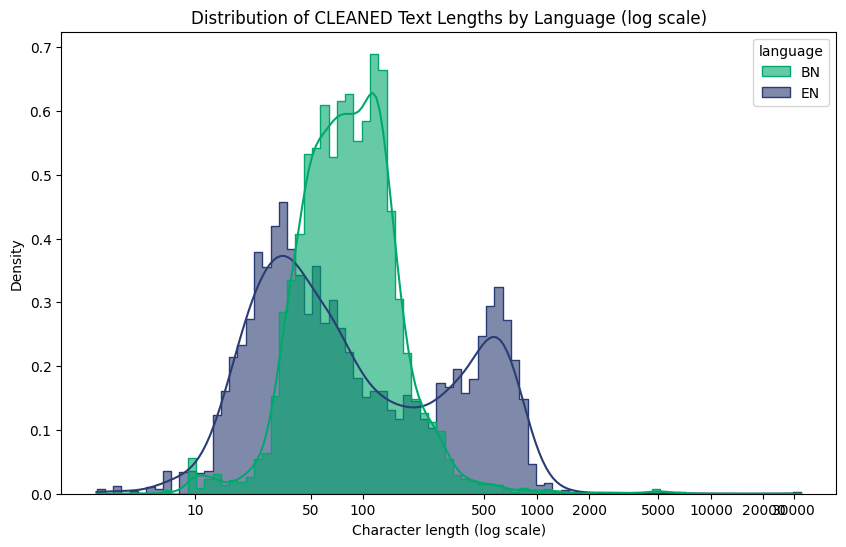

In [17]:
import numpy as np

# Add a small constant to avoid log(0)
df['log_cleaned_length'] = np.log1p(df['cleaned_text_length'])

plt.figure(figsize=(10,6))
sns.histplot(
    data=df,
    x='log_cleaned_length',
    hue='language',
    kde=True,
    palette={'BN':'#00A86B','EN':'#2A3C74'},
    alpha=0.6,
    element='step',
    stat='density',
    common_norm=False
)

plt.xticks(
    ticks=np.log1p([10,50,100,500,1000,2000,5000,10000,20000,30000]),
    labels=[10,50,100,500,1000,2000,5000,10000,20000,30000]
)
plt.xlabel('Character length (log scale)')
plt.ylabel('Density')
plt.title('Distribution of CLEANED Text Lengths by Language (log scale)')
plt.show()

## Train/Test/Validation Split (70/15/15)

In [18]:
# Split based on unique texts to avoid leakage
unique_texts = df[['processed_text', 'label']].drop_duplicates()

# Split unique texts into train and temp
train_texts, temp_texts = train_test_split(
    unique_texts,
    test_size=0.3,
    stratify=unique_texts['label'],
    random_state=42
)

# Split temp into val and test
val_texts, test_texts = train_test_split(
    temp_texts,
    test_size=0.5,
    stratify=temp_texts['label'],
    random_state=42
)

# Map back to full dataframe
df_train = df[df['processed_text'].isin(train_texts['processed_text'])]
df_val   = df[df['processed_text'].isin(val_texts['processed_text'])]
df_test  = df[df['processed_text'].isin(test_texts['processed_text'])]

print(f"Train: {len(df_train)}, Validation: {len(df_val)}, Test: {len(df_test)}")

Train: 6991, Validation: 1487, Test: 1476


## Balance fake vs real inside each language

In [19]:
from sklearn.utils import resample

def balance_train_by_lang_and_label(train_df):
    balanced_groups = []

    for lang in train_df['language'].unique():
        sub = train_df[train_df['language'] == lang]

        fake = sub[sub['label'] == 0]
        real = sub[sub['label'] == 1]

        min_count = min(len(fake), len(real))

        fake_down = resample(fake, replace=False, n_samples=min_count, random_state=42)
        real_down = resample(real, replace=False, n_samples=min_count, random_state=42)

        balanced_groups.append(pd.concat([fake_down, real_down]))

    balanced_train = pd.concat(balanced_groups)
    return balanced_train.sample(frac=1, random_state=42).reset_index(drop=True)


In [22]:
df_train = balance_train_by_lang_and_label(df_train)
print("TRAIN (balanced):")
print(df_train.groupby(['language','label']).size())

print("\nVAL (original):")
print(df_val.groupby(['language','label']).size())

print("\nTEST (original):")
print(df_test.groupby(['language','label']).size())


TRAIN (balanced):
language  label
BN        0        1739
          1        1739
EN        0        1431
          1        1431
dtype: int64

VAL (original):
language  label
BN        0        443
          1        373
EN        0        376
          1        295
dtype: int64

TEST (original):
language  label
BN        0        429
          1        366
EN        0        378
          1        303
dtype: int64


## Function to create TensorDataset

In [23]:
def create_dataset(dataframe, tokenizer, max_len):
    tokenized = tokenizer(
        dataframe['processed_text'].tolist(),
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    labels = torch.tensor(dataframe['label'].tolist(), dtype=torch.long)
    return TensorDataset(tokenized['input_ids'], tokenized['attention_mask'], labels)

## Function to save datasets for multiple models

In [24]:
def save_datasets_for_models(models, df_train, df_val, df_test, output_dir='/kaggle/working/textdata'):
    os.makedirs(output_dir, exist_ok=True)
    
    for model_name in models:
        print(f"\nProcessing model: {model_name}")
        
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        
        # Compute MAX_LEN for this model
        df_all = pd.concat([df_train, df_val, df_test])
        df_all['token_length'] = df_all['processed_text'].apply(
            lambda x: len(tokenizer.encode(x, add_special_tokens=True, truncation=False))
        )
        max_len = int(df_all['token_length'].quantile(0.95))
        print(f"Optimal MAX_LEN (95th percentile) for {model_name}: {max_len}")
        
        # Create datasets
        train_dataset = create_dataset(df_train, tokenizer, max_len)
        val_dataset = create_dataset(df_val, tokenizer, max_len)
        test_dataset = create_dataset(df_test, tokenizer, max_len)
        
        # Save datasets
        for split_name, dataset in zip(['train','val','test'], [train_dataset, val_dataset, test_dataset]):
            file_path = os.path.join(output_dir, f"{split_name}_tensors_{model_name.replace('/', '-')}.pt")
            torch.save({
                "input_ids": dataset.tensors[0],
                "attention_mask": dataset.tensors[1],
                "labels": dataset.tensors[2]
            }, file_path)
            print(f"Saved {split_name} dataset for {model_name} -> {file_path}")


## Generate datasets for multiple models

In [26]:
model_list = [
    'xlm-roberta-base',
    'bert-base-multilingual-cased',
    'bert-base-multilingual-uncased',
    'distilbert-base-multilingual-cased'
]

save_datasets_for_models(model_list, df_train, df_val, df_test)

print("\nAll datasets are ready for training!")


Processing model: xlm-roberta-base


Token indices sequence length is longer than the specified maximum sequence length for this model (797 > 512). Running this sequence through the model will result in indexing errors


Optimal MAX_LEN (95th percentile) for xlm-roberta-base: 138
Saved train dataset for xlm-roberta-base -> /kaggle/working/textdata/train_tensors_xlm-roberta-base.pt
Saved val dataset for xlm-roberta-base -> /kaggle/working/textdata/val_tensors_xlm-roberta-base.pt
Saved test dataset for xlm-roberta-base -> /kaggle/working/textdata/test_tensors_xlm-roberta-base.pt

Processing model: bert-base-multilingual-cased


Token indices sequence length is longer than the specified maximum sequence length for this model (1325 > 512). Running this sequence through the model will result in indexing errors


Optimal MAX_LEN (95th percentile) for bert-base-multilingual-cased: 140
Saved train dataset for bert-base-multilingual-cased -> /kaggle/working/textdata/train_tensors_bert-base-multilingual-cased.pt
Saved val dataset for bert-base-multilingual-cased -> /kaggle/working/textdata/val_tensors_bert-base-multilingual-cased.pt
Saved test dataset for bert-base-multilingual-cased -> /kaggle/working/textdata/test_tensors_bert-base-multilingual-cased.pt

Processing model: bert-base-multilingual-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1247 > 512). Running this sequence through the model will result in indexing errors


Optimal MAX_LEN (95th percentile) for bert-base-multilingual-uncased: 131
Saved train dataset for bert-base-multilingual-uncased -> /kaggle/working/textdata/train_tensors_bert-base-multilingual-uncased.pt
Saved val dataset for bert-base-multilingual-uncased -> /kaggle/working/textdata/val_tensors_bert-base-multilingual-uncased.pt
Saved test dataset for bert-base-multilingual-uncased -> /kaggle/working/textdata/test_tensors_bert-base-multilingual-uncased.pt

Processing model: distilbert-base-multilingual-cased


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1325 > 512). Running this sequence through the model will result in indexing errors


Optimal MAX_LEN (95th percentile) for distilbert-base-multilingual-cased: 140
Saved train dataset for distilbert-base-multilingual-cased -> /kaggle/working/textdata/train_tensors_distilbert-base-multilingual-cased.pt
Saved val dataset for distilbert-base-multilingual-cased -> /kaggle/working/textdata/val_tensors_distilbert-base-multilingual-cased.pt
Saved test dataset for distilbert-base-multilingual-cased -> /kaggle/working/textdata/test_tensors_distilbert-base-multilingual-cased.pt

All datasets are ready for training!


In [27]:
import shutil

shutil.make_archive('/kaggle/working/textdata', 'zip', '/kaggle/working/textdata')


'/kaggle/working/textdata.zip'